In [2]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [3]:
from itertools import product

import matplotlib
import matplotlib.pyplot as plt
import spiceypy as spice
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.special import lpmv
import pyshtools as pysh
from pyshtools.legendre import legendre_lm
from skimage.io import imread
from skimage.filters.rank import mean
from skimage.morphology import square
from skimage.measure import block_reduce
from skimage.metrics import normalized_root_mse

In [4]:
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.spice_tools import as_et
from lropy.analysis.maps import moon_globe

# Reference frames

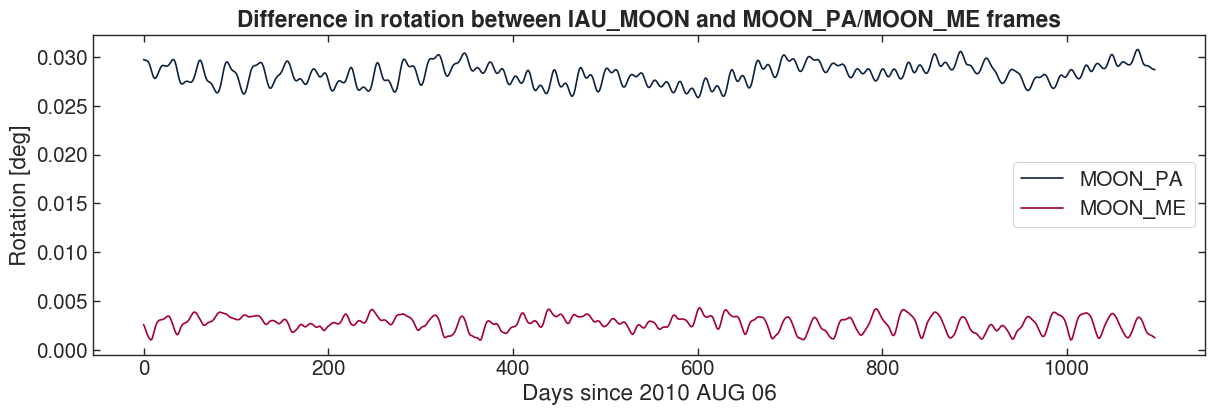

In [5]:
def plot_moon_frame_difference():
    def quat_to_deg(q):
        ang_rad = 2 * np.arctan2(np.linalg.norm(q[1:]), q[0])
        return np.degrees(ang_rad)

    plt.subplots(figsize=(12, 4))

    t_start = as_et("2010 AUG 06")
    n_years = 3
    t = np.linspace(t_start, t_start + n_years * 365 * 24 * 3600, 1000)

    plt.plot(
        (t - t_start) / (3600 * 24),
        np.vectorize(lambda tt: quat_to_deg(spice.m2q(spice.pxform("MOON_PA", "IAU_MOON", tt))))(t),
        label="MOON_PA")
    plt.plot(
        (t - t_start) / (3600 * 24),
        np.vectorize(lambda tt: quat_to_deg(spice.m2q(spice.pxform("MOON_ME", "IAU_MOON", tt))))(t),
        label="MOON_ME")

    plt.xlabel("Days since 2010 AUG 06")
    plt.ylabel("Rotation [deg]")
    plt.title(f"Difference in rotation between IAU_MOON and MOON_PA/MOON_ME frames")
    plt.legend()

    format_plot()

plot_moon_frame_difference()

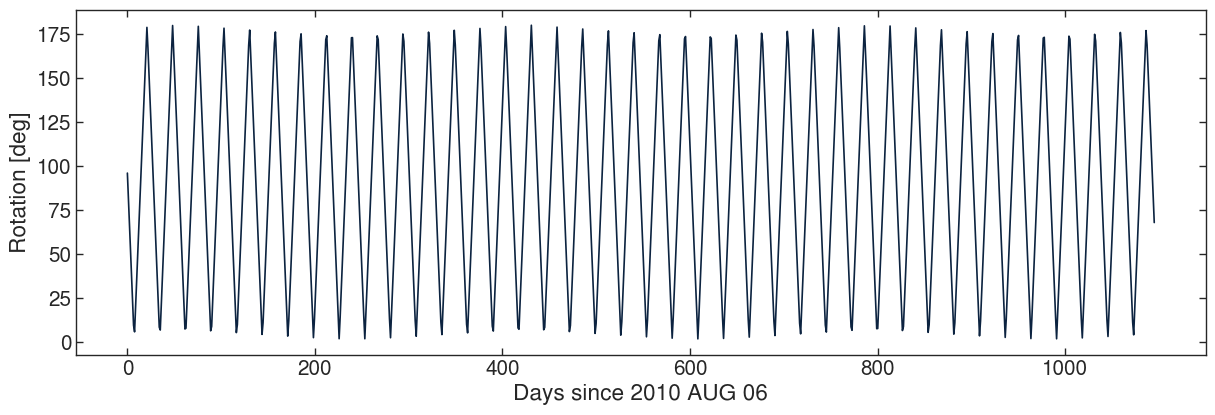

In [6]:
def plot_moon_eclip_difference():
    def quat_to_deg(q):
        ang_rad = 2 * np.arctan2(np.linalg.norm(q[1:]), q[0])
        return np.degrees(ang_rad)

    plt.subplots(figsize=(12, 4))

    t_start = as_et("2010 AUG 06")
    n_years = 3
    t = np.linspace(t_start, t_start + n_years * 365 * 24 * 3600, 1000)

    plt.plot(
        (t - t_start) / (3600 * 24),
        np.vectorize(lambda tt: quat_to_deg(spice.m2q(spice.pxform("MOON_ME", "ECLIPJ2000", tt))))(t))

    plt.xlabel("Days since 2010 AUG 06")
    plt.ylabel("Rotation [deg]")

    format_plot()

plot_moon_eclip_difference()

# Angle-based thermal radiation

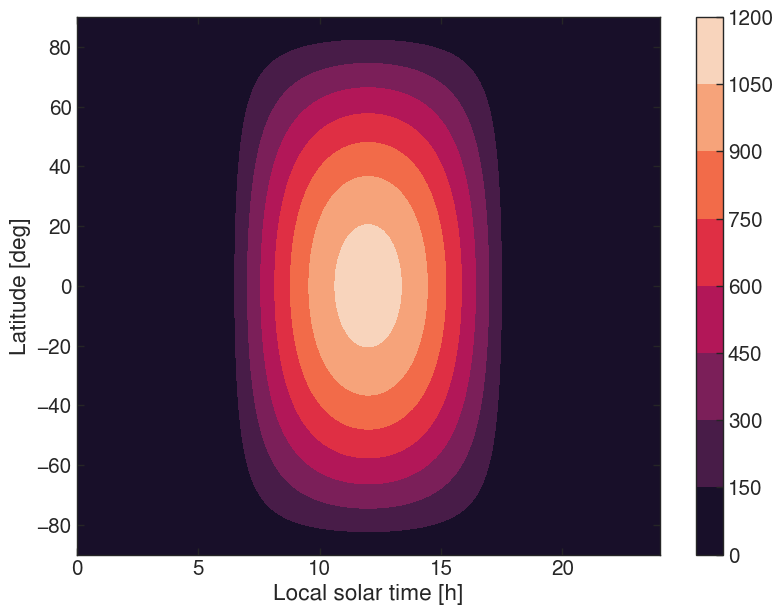

In [7]:
def thermal_radiation(polar, azimuth):
        subsolar = np.array([1, 0, 0])
        normal = np.array([
            np.cos(azimuth) * np.sin(polar),
            np.sin(azimuth) * np.sin(polar),
            np.cos(polar)
        ])
        cosphi = max(0, subsolar @ normal)
        
        sigma = 5.670374419e-8
        T = max(375 * cosphi**(1/4), 100)
        return sigma * T**4

def plot_thermal_lemoine():
    # Recreate Fig. 5 from Lemoine 2013
    polarlist = np.linspace(0, 1, 100) * np.pi
    azimuthlist = np.linspace(-1, 1, 100) * np.pi
    polars, azimuths = np.meshgrid(polarlist, azimuthlist)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    exitances = np.vectorize(thermal_radiation)(polars, azimuths)
    im = ax.contourf((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances)
    fig.colorbar(im, ax=ax)
    ax.set_xlabel("Local solar time [h]")
    ax.set_ylabel("Latitude [deg]")

    format_plot()
    
plot_thermal_lemoine()

In [8]:
thermal_radiation(np.pi / 2, 0)

1121.3386912573242

Maximum is 1121 W/m^2, which agrees with Lemoine (2013).

In [9]:
thermal_radiation(np.pi / 2, np.pi)

5.670374419

Minimum is 5.7 W/m^2.

# SH albedo distribution

$$
a = \sum_{l=0}^\infty \sum_{m=0}^l ...
$$
* $n=l$: degree
* $m$: order

In [50]:
def read_coeffs(scaled=True):
   # DLAM-1 coefficients are in GEODYN format
   # See https://earth.gsfc.nasa.gov/sites/default/files/volume3.pdf
   with open("files/DLAM-1.txt") as f:
       lines = f.readlines()
   lines = [line[8:-1] for line in lines[5:]]
   
   cos_coeffs = np.zeros((16, 16))
   sin_coeffs = np.zeros((16, 16))

   for line in lines:
      l = int(line[:2])
      m = int(line[2:4])
      
      cos_coeffs[l, m] = float(line[20:36].replace("D", "E"))
      sin_coeffs[l, m] = float(line[36:].replace("D", "E"))
   
   if scaled:
      cos_coeffs = cos_coeffs / 1.3
      sin_coeffs = sin_coeffs / 1.3
   return cos_coeffs, sin_coeffs

cos_coeffs, sin_coeffs = read_coeffs()

In [75]:
# with np.printoptions(precision=2, linewidth=1000):
#     print("rows = degree, cols = order")
#     print(sin_coeffs)

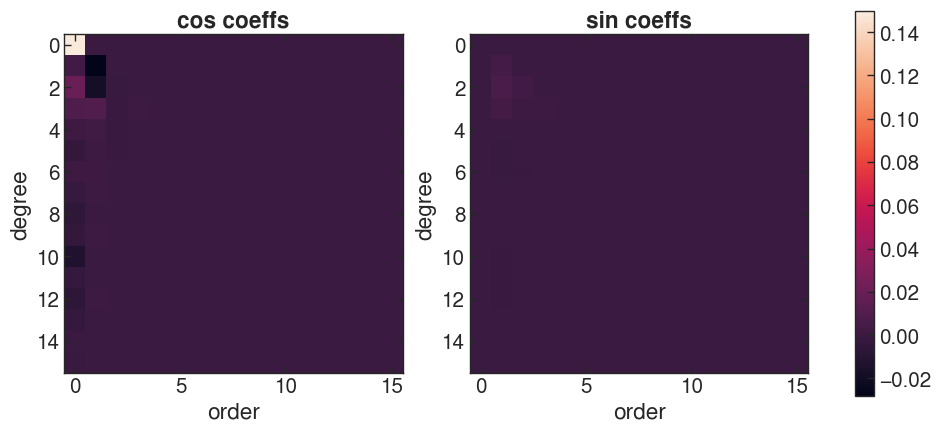

In [52]:
def plot_coeffs():
    vmin = min(cos_coeffs.min(), sin_coeffs.min())
    vmax = max(cos_coeffs.max(), sin_coeffs.max())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(cos_coeffs, vmin=vmin, vmax=vmax)
    ax1.set_title("cos coeffs")
    ax1.set_xlabel("order")
    ax1.set_ylabel("degree")

    im = ax2.imshow(sin_coeffs, vmin=vmin, vmax=vmax)
    ax2.set_title("sin coeffs")
    ax2.set_xlabel("order")
    ax2.set_ylabel("degree")

    plt.colorbar(im, ax=[ax1, ax2])

plot_coeffs()

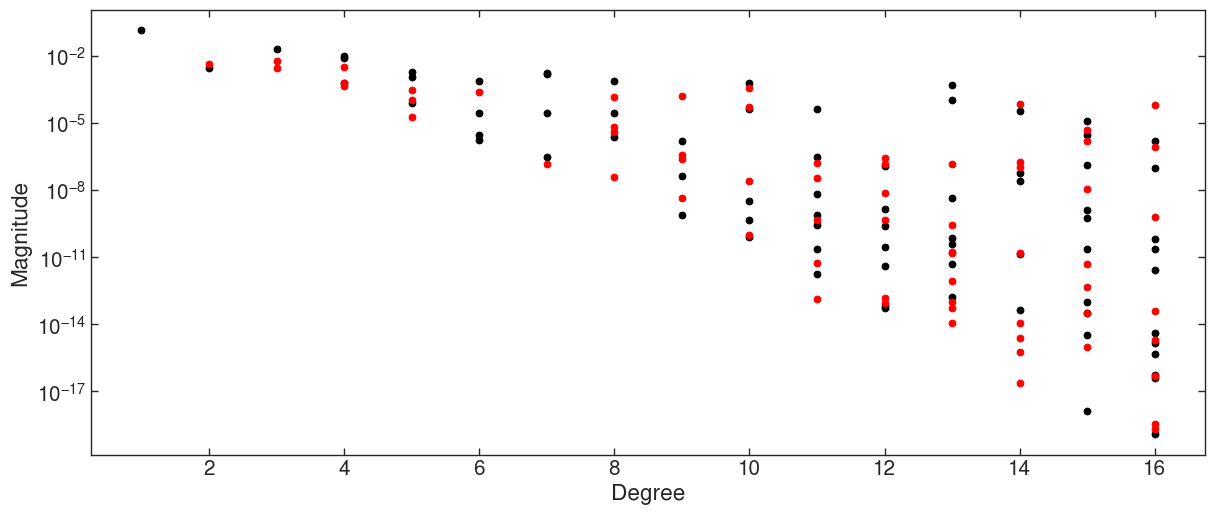

In [53]:
def plot_coeff_decay():
    max_degree = cos_coeffs.shape[0]

    fig, ax = plt.subplots(figsize=(12, 5))

    for degree in range(1, max_degree + 1):
        for order, coeff in enumerate(cos_coeffs[degree-1, :]):
            if coeff > 0:
                ax.scatter(degree, coeff, c="black")
        for order, coeff in enumerate(sin_coeffs[degree-1, :]):
            if coeff > 0:
                ax.scatter(degree, coeff, c="red")

    ax.set_xlabel("Degree")
    ax.set_ylabel("Magnitude")
    ax.set_yscale("log")

    format_plot()

plot_coeff_decay()

In [54]:
def dlam1(lat, lon, degrees=True):
   if degrees:
      lat = np.radians(lat)
      lon = np.radians(lon)
   sin_lat = np.sin(lat)

   a = 0
   for l in range(0, 16):
      for m in range(0, l+1):
         # (-1)^m to remove Condon-Shortley phase of lpmv
         Pnm = (-1)**m * lpmv(m, l, sin_lat)
         a += (
            cos_coeffs[l, m] * np.cos(m * lon) + sin_coeffs[l, m] * np.sin(m * lon)
         ) * Pnm
   return a

dlam1(60, 20)

0.13106679585795558

Check that sectoral average of DLAM-1 converges to C0,0:

In [55]:
np.mean(np.vectorize(dlam1)(30, np.linspace(-180, 180, 100))) - cos_coeffs[0, 0]

-0.0030730027944910476

Check that zonal average of DLAM-1 converges to C0,0:

In [56]:
np.mean(np.vectorize(dlam1)(np.linspace(-90, 90, 100), 48)) - cos_coeffs[0, 0]

0.005867340307936536

In [57]:
def generate_albedo_map_manual():
   step = 1
   lats = range(-90, 90, step)
   lons = range(-180, 180, step)

   albedo_map = np.empty((180, 360))
   for lat, lon in product(lats, lons):
      albedo_map[lat + 90, lon + 180] = dlam1(lat, lon)

   # Flip latitude
   albedo_map = np.flipud(albedo_map[::step, ::step])

   return albedo_map

albedo_map_manual = generate_albedo_map_manual()

In [58]:
def plot_albedo_map(albedo_map):
    fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True, subplot_kw=dict(projection=ccrs.PlateCarree(globe=moon_globe)))
    ax.set_title(f"Albedo map (min = {albedo_map.min():.2f}, max = {albedo_map.max():.2f})")

    im = ax.imshow(albedo_map, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.3)
    plt.colorbar(im)
    ax.gridlines(draw_labels=["bottom", "left"], crs=ccrs.PlateCarree(globe=moon_globe))

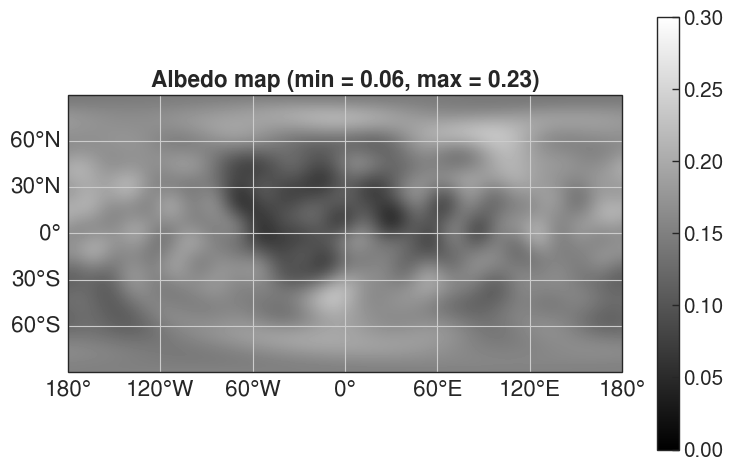

In [59]:
plot_albedo_map(albedo_map_manual)

Agrees with Fig. 16a of Sato 2014.

In [60]:
def generate_albedo_map_shtools(step=1):
    sh = pysh.SHCoeffs.from_array(np.stack([cos_coeffs, sin_coeffs]), normalization="unnorm")

    lats = np.arange(-90, 90, step)
    lons = np.arange(-180, 180, step)
    coords_lat, coords_lon = np.meshgrid(lats, lons, indexing="ij")
    albedo_map = sh.expand(lat=coords_lat, lon=coords_lon)

    # grid = sh.expand(grid="DH2")
    # albedo_map = grid.data
    # lats = grid.lats()
    # lons = grid.lons()

    # Flip latitude
    albedo_map = np.flipud(albedo_map)

    return albedo_map

albedo_map_shtools = generate_albedo_map_shtools()

In [76]:
# np.save("../private/dlam1.npy", generate_albedo_map_shtools(0.5))

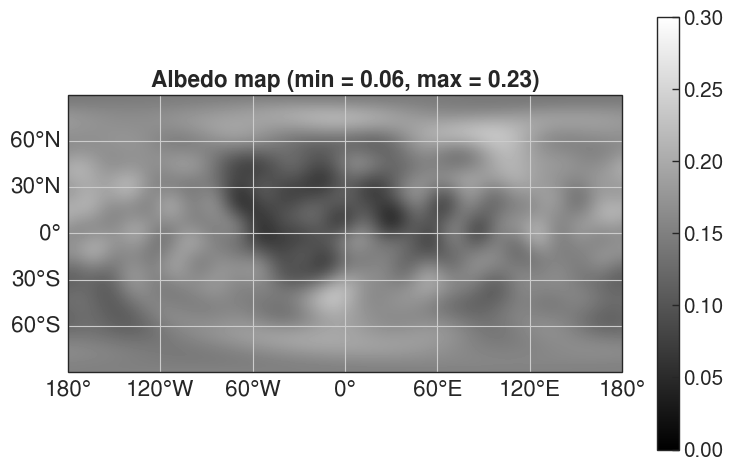

In [62]:
plot_albedo_map(albedo_map_shtools)

In [63]:
# from skimage import color, io, measure, img_as_ubyte, img_as_float

# im = albedo_map_shtools
# im = img_as_ubyte(color.gray2rgb(im))
# io.imsave("albedomap.png", im)
# io.imshow(im, cmap="gray")
# io.show()

In [64]:
f"RMS deviation of SF reconstructions: {normalized_root_mse(albedo_map_manual, albedo_map_shtools):.1%}"

'RMS deviation of SF reconstructions: 0.0%'

In [106]:
def tf_mosaic(dist):
    dist = dist.astype(np.double)
    dist -= 1
    dist /= 255
    dist = dist * (0.5 - 0.048) + 0.048
    return dist

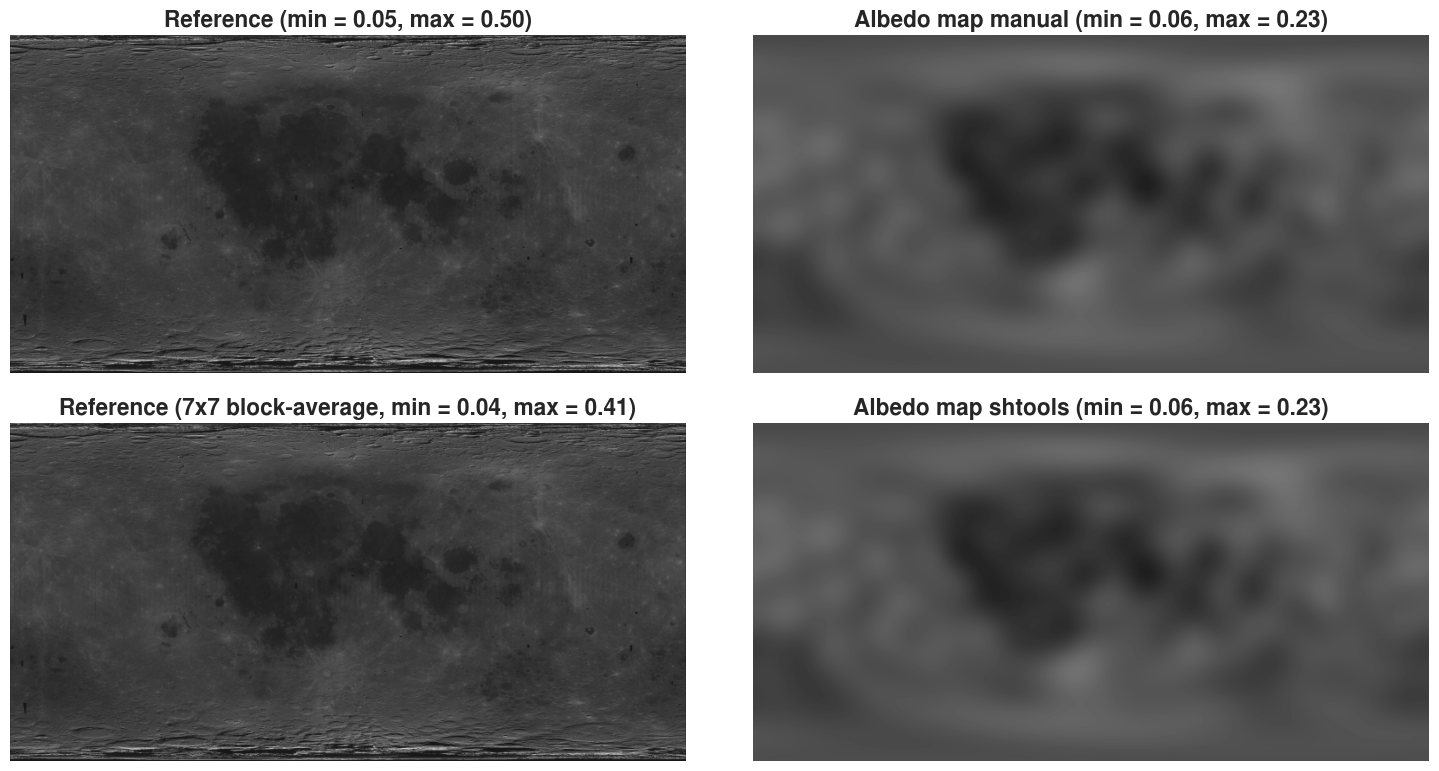

In [107]:
def plot_albedo_map_comparison(albedo_map_manual, albedo_map_shtools):
    ref = tf_mosaic(imread("files/albedo.jpg"))
    # ref_blur = mean(ref, square(7))
    ref_blur = block_reduce(ref, 7, np.mean)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), tight_layout=True)

    ax1.imshow(ref, cmap="gray", vmin=0, vmax=0.5)
    ax1.axis("off")
    ax1.set_title(f"Reference (min = {ref.min():.2f}, max = {ref.max():.2f})")

    ax2.imshow(albedo_map_manual, cmap="gray", vmin=0, vmax=0.5)
    ax2.axis("off")
    ax2.set_title(f"Albedo map manual (min = {albedo_map_manual.min():.2f}, max = {albedo_map_manual.max():.2f})")

    ax3.imshow(ref_blur, cmap="gray", vmin=0, vmax=0.5)
    ax3.axis("off")
    ax3.set_title(f"Reference (7x7 block-average, min = {ref_blur.min():.2f}, max = {ref_blur.max():.2f})")

    ax4.imshow(albedo_map_shtools, cmap="gray", vmin=0, vmax=0.5)
    ax4.axis("off")
    ax4.set_title(f"Albedo map shtools (min = {albedo_map_shtools.min():.2f}, max = {albedo_map_shtools.max():.2f})")

plot_albedo_map_comparison(albedo_map_manual, albedo_map_shtools)

Clementine mosaic (left) is quantized to integers, even for the 32 bit float image.

In [77]:
albedo_map_manual.mean(), albedo_map_shtools.mean()

(0.15362941576779313, 0.15362941576779313)

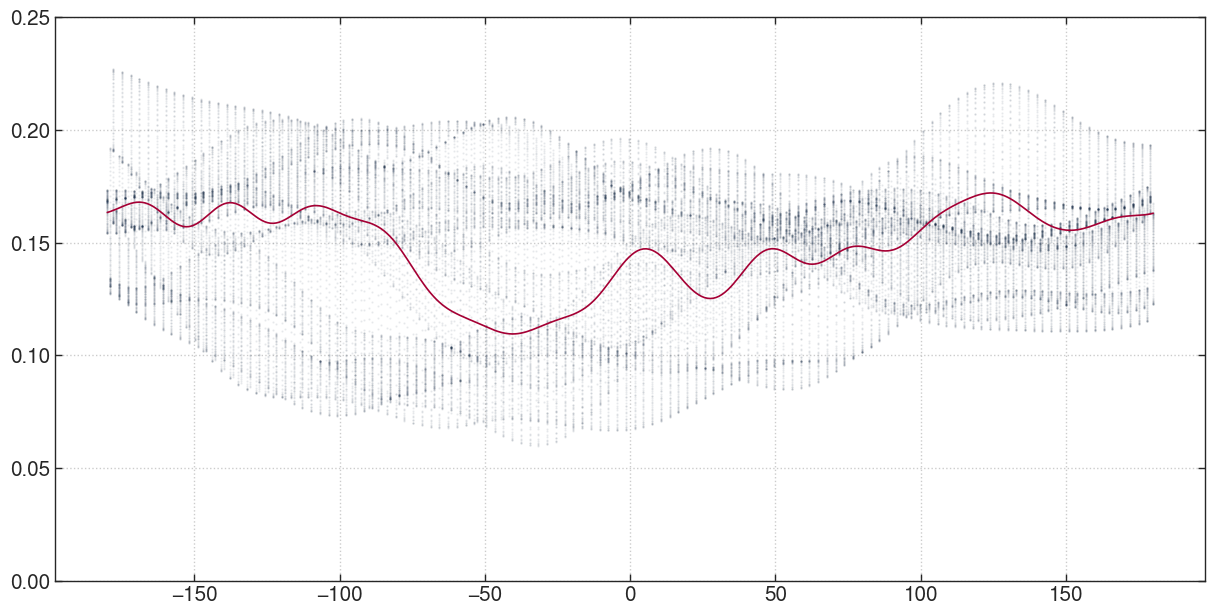

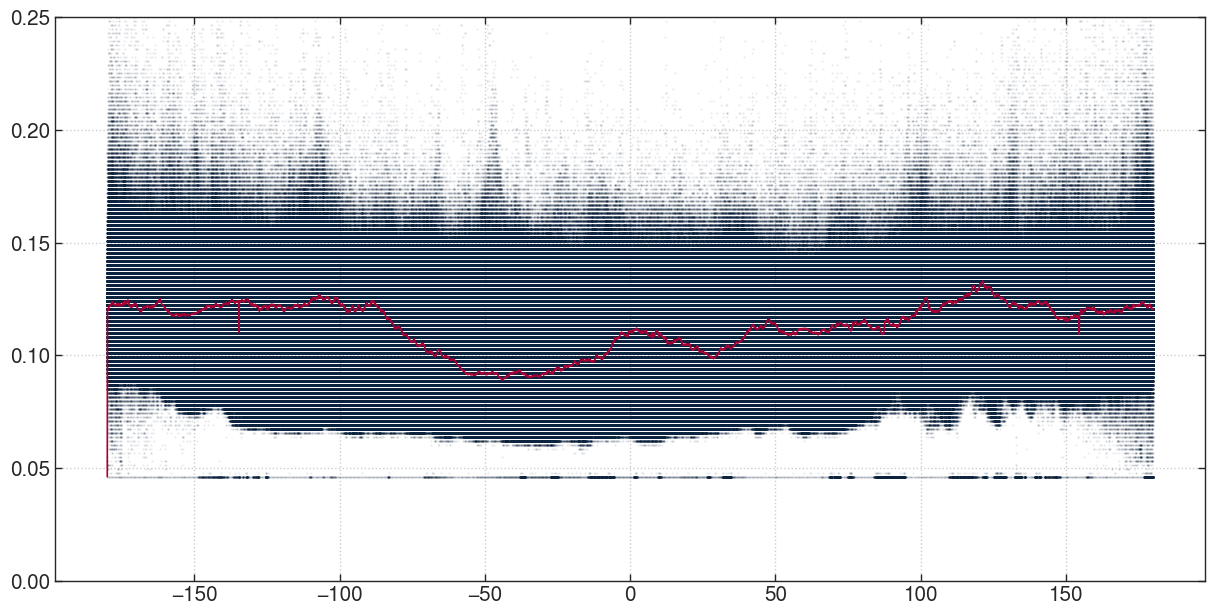

In [126]:
def plot_longitudinal_distribution(dist):
    lat_cutoff = int(30 / 180 * dist.shape[0])
    dist = dist[lat_cutoff:-lat_cutoff, :]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(np.repeat(np.linspace(-180, 180, dist.shape[1]), dist.shape[0]), dist.flatten(), s=1, alpha=0.05)
    plt.plot(np.linspace(-180, 180, dist.shape[1]), dist.mean(axis=0), c="C1")
    plt.ylim([0, 0.25])
    format_plot(major_grid=True)

plot_longitudinal_distribution(albedo_map_shtools)
plot_longitudinal_distribution(tf_mosaic(imread("files/albedo.jpg")))

Compare with Vasavada 2012, Fig. 2:
* They have a much more abrupt decrease at -70 deg
* DLAM-1 agrees with Vasavada in highlands
* Clementine moasic agrees with Vasavada in maria
* Overall shape is similar

In [84]:
def generate_initializer_list(coeffs):
    st = "{\n"
    for row in range(coeffs.shape[0]):
        st += "    {"
        for col in range(coeffs.shape[1]):
            st += f"{coeffs[row, col]:+0.7e}" + ", "
        st = st[:-2]
        st += "},\n"
    st = st[:-2]
    st += "\n}"
    print(st)

cos_coeffs_unscaled, sin_coeffs_unscaled = read_coeffs(scaled=False)
generate_initializer_list(cos_coeffs_unscaled)
generate_initializer_list(sin_coeffs_unscaled)

{
    {+1.9467246e-01, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00},
    {+3.7619635e-03, -3.6562523e-02, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00},
    {+2.6013759e-02, -2.3342472e-02, -1.5511737e-03, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00},
    {+1.0791359e-02, +1.2984099e-02, -5.1947501e-04, +8.3037838e-04, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00, +0.0000000e+00,

## Unit test data for test_surfacePropertyDistributionSetup_SphericalHarmonics_DLAM1 in unitTestEnvironmentModelSetup

Note: these coefficients include the factor 1/1.3 and therefore are not identical with DLAM-1.txt

In [123]:
cos_coeffs[7, 6]

-4.041203307692307e-08

In [124]:
sin_coeffs[10, 3]

-4.987361846153846e-06

In [92]:
with np.printoptions(precision=20):
    print(dlam1(0.7, 0.42, degrees=False))
    print(dlam1(-1.5, 0.9, degrees=False))

0.11846922315451458
0.15772976227190455
